In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
labels_per_class = 'full' # full

### Load packages

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [6]:
from tfumap.load_datasets import load_FMNIST, mask_labels
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_FMNIST(flatten=False)
X_train.shape

(50000, 28, 28, 1)

In [7]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

In [8]:
num_classes=10

In [9]:
Y_valid_one_hot = tf.keras.backend.one_hot(
    Y_valid, num_classes
)

In [10]:
Y_labeled_one_hot = tf.keras.backend.one_hot(
    Y_labeled, num_classes
)

### Network architecture

In [11]:
dims = (28,28,1)
n_components= 2


In [12]:
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu"
    ),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=512, activation="relu"),
])

In [13]:
embedder = tf.keras.Sequential()
embedder.add(tf.keras.Input(shape=(512)))
embedder.add(tf.keras.layers.Dense(256, activation="relu"))
embedder.add(tf.keras.layers.Dense(256, activation="relu"))
embedder.add(tf.keras.layers.Dense(n_components, activation=None, name='z_'))

In [14]:
classifier = tf.keras.Sequential()
classifier.add(tf.keras.Input(shape=(512)))
classifier.add(tf.keras.layers.Dense(256, activation="relu"))
classifier.add(tf.keras.layers.Dense(256, activation="relu"))
classifier.add(tf.keras.layers.Dense(num_classes, activation=None, name='y_'))

### Test model with just UMAP

In [15]:
from tfumap.semisupervised import find_a_b
from tfumap.umap import convert_distance_to_probability

In [16]:
min_dist = 0.0
_a, _b = find_a_b(min_dist)
_a, _b 

(<tf.Tensor: shape=(), dtype=float32, numpy=1.9328084>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.790495>)

##### build iterator

In [17]:
from tfumap.semisupervised import build_fuzzy_simplicial_set
from tfumap.umap import compute_cross_entropy, get_graph_elements

In [18]:
n_neighbors = 15  # default = 15
umap_graph = build_fuzzy_simplicial_set(
    X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:]))),
    y=Y_masked,
    n_neighbors=n_neighbors,
)

In [19]:
n_epochs = 200
graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(
            umap_graph, n_epochs
)
batch_size = np.min([n_vertices, 1000])
batch_size

1000

In [20]:
max_sample_repeats_per_epoch = 25
# set the maximum number of times each edge should be repeated per epoch
epochs_per_sample = np.clip(
    (weight / np.max(weight)) * max_sample_repeats_per_epoch,
    1,
    max_sample_repeats_per_epoch,
).astype("int")

In [21]:
edges_to_exp, edges_from_exp = (
        np.repeat(head, epochs_per_sample.astype("int")),
       np.repeat(tail, epochs_per_sample.astype("int")),
)
shuffle_mask = np.random.permutation(range(len(edges_to_exp)))
edges_to_exp = edges_to_exp[shuffle_mask]
edges_from_exp = edges_from_exp[shuffle_mask]

In [22]:
negative_sample_rate = 5

In [23]:
def gather_X(edge_to, edge_from):
    return (tf.gather(X_train, edge_to), tf.gather(X_train, edge_from)), 0

In [24]:
edge_iter = tf.data.Dataset.from_tensor_slices((edges_to_exp, edges_from_exp))
edge_iter = edge_iter.shuffle(10000)
edge_iter = edge_iter.map(gather_X, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [85]:
labeled_dataset = tf.data.Dataset.from_tensor_slices((X_labeled, Y_labeled_one_hot)).shuffle(len(X_labeled)).repeat()
labeled_dataset

<RepeatDataset shapes: ((28, 28, 1), (10,)), types: (tf.float32, tf.float32)>

In [86]:
def rearrange_output(label_iter_out, edge_iter_out):
    X_lab, Y_lab = label_iter_out
    (X_to, X_from), edge_prob = edge_iter_out
    return (X_lab, X_to, X_from), {"classifier":Y_lab, "umap": edge_prob}

In [87]:
zipped_ds = tf.data.Dataset.zip((labeled_dataset, edge_iter))
zipped_ds = zipped_ds.map(rearrange_output, num_parallel_calls=tf.data.experimental.AUTOTUNE)
zipped_ds = zipped_ds.batch(batch_size, drop_remainder=True)
zipped_ds

<BatchDataset shapes: (((1000, 28, 28, 1), (1000, 28, 28, 1), (1000, 28, 28, 1)), {classifier: (1000, 10), umap: (1000,)}), types: ((tf.float32, tf.float32, tf.float32), {classifier: tf.float32, umap: tf.int32})>

In [88]:
(X_lab, X_to, X_from), test  = next(iter(zipped_ds))
X_lab.shape, X_to.shape, X_from.shape

(TensorShape([1000, 28, 28, 1]),
 TensorShape([1000, 28, 28, 1]),
 TensorShape([1000, 28, 28, 1]))

#### Build network

In [91]:
def umap_loss(batch_size, negative_sample_rate, _a, _b, repulsion_strength = 1.0):
    @tf.function
    def loss(placeholder_y, embed_to_from):
        # split out to/from
        embedding_to, embedding_from = tf.split(embed_to_from, num_or_size_splits=2, axis=1)

        # get negative samples
        embedding_neg_to = tf.repeat(embedding_to, negative_sample_rate, axis=0)
        repeat_neg = tf.repeat(embedding_from, negative_sample_rate, axis=0)
        embedding_neg_from = tf.gather(
            repeat_neg, tf.random.shuffle(tf.range(tf.shape(repeat_neg)[0]))
        )

        #  distances between samples (and negative samples)
        distance_embedding = tf.concat(
            [
                tf.norm(embedding_to - embedding_from, axis=1),
                tf.norm(embedding_neg_to - embedding_neg_from, axis=1),
            ],
            axis=0,
        )

        # convert probabilities to distances
        probabilities_distance = convert_distance_to_probability(
            distance_embedding, _a, _b
        )
        
        # set true probabilities based on negative sampling
        probabilities_graph = tf.concat(
            [tf.ones(batch_size), tf.zeros(batch_size * negative_sample_rate)],
            axis=0,
        )
                
        # compute cross entropy
        (attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
            probabilities_graph,
            probabilities_distance,
            repulsion_strength=repulsion_strength,
        )
        return tf.reduce_mean(ce_loss)

    return loss

In [92]:
from tensorflow.keras.layers import Input

In [93]:
to_x = Input(shape=dims, name = "to_x")
from_x = Input(shape=dims, name = "from_x")
classifier_x = Input(shape=dims, name = "classifier_x")


embedding_to = embedder(encoder(to_x))
embedding_from = embedder(encoder(from_x))
embedding_to_from = tf.concat([embedding_to, embedding_from], axis = 1)
embedding_to_from = tf.keras.layers.Lambda(lambda x: x, name='umap')(embedding_to_from)

predictions = classifier(encoder(classifier_x))
predictions = tf.keras.layers.Lambda(lambda x: x, name='classifier')(predictions)

model = tf.keras.Model(
    inputs=[classifier_x, to_x, from_x],
    outputs={"classifier": predictions, "umap":embedding_to_from},
)

In [94]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss={
        "classifier": tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2, from_logits=True),
        "umap": umap_loss(batch_size, negative_sample_rate, _a, _b),
    },
    loss_weights = {
        "classifier": 1.0,
        "umap": 1.0,
    },
    metrics={"classifier":"accuracy"}

)

In [96]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_classifier_loss', min_delta=0, patience=50, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

In [99]:
num_batches = np.floor(len(X_train)/batch_size).astype(int)
num_batches

50

In [108]:
history = model.fit(
    zipped_ds,
    epochs=100,
    validation_data=(
        (X_valid, tf.zeros_like(X_valid), tf.zeros_like(X_valid)),
        {"classifier": Y_valid_one_hot},
    ),
    callbacks = [early_stopping],
    max_queue_size = 100,
    steps_per_epoch = num_batches
)

Epoch 1/100
 1/50 [..............................] - ETA: 0s - loss: 0.9313 - classifier_loss: 0.8675 - umap_loss: 0.0637 - classifier_accuracy: 1.0000

W0810 21:43:15.528486 139815396386624 callbacks.py:328] Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0068s vs `on_train_batch_end` time: 0.0137s). Check your callbacks.


50/50 [==============================] - 2s 34ms/step - loss: 0.9325 - classifier_loss: 0.8679 - umap_loss: 0.0646 - classifier_accuracy: 0.9996 - val_loss: 1.0960 - val_classifier_loss: 1.0960 - val_umap_loss: 0.0000e+00 - val_classifier_accuracy: 0.9084
Epoch 2/100
50/50 [==============================] - 2s 34ms/step - loss: 0.9324 - classifier_loss: 0.8676 - umap_loss: 0.0648 - classifier_accuracy: 0.9997 - val_loss: 1.0951 - val_classifier_loss: 1.0951 - val_umap_loss: 0.0000e+00 - val_classifier_accuracy: 0.9080
Epoch 3/100
50/50 [==============================] - 2s 35ms/step - loss: 0.9314 - classifier_loss: 0.8674 - umap_loss: 0.0640 - classifier_accuracy: 0.9998 - val_loss: 1.0964 - val_classifier_loss: 1.0964 - val_umap_loss: 0.0000e+00 - val_classifier_accuracy: 0.9097
Epoch 4/100
50/50 [==============================] - 2s 34ms/step - loss: 0.9326 - classifier_loss: 0.8672 - umap_loss: 0.0653 - classifier_accuracy: 0.9999 - val_loss: 1.0923 - val_classifier_loss: 1.0923 - 

KeyboardInterrupt: 

In [109]:
pred_test = classifier.predict(encoder.predict(X_test))

In [110]:
np.mean(np.argmax(pred_test, axis = 1) == Y_test)

0.9148

In [111]:
z = embedder.predict(encoder.predict(X_train))

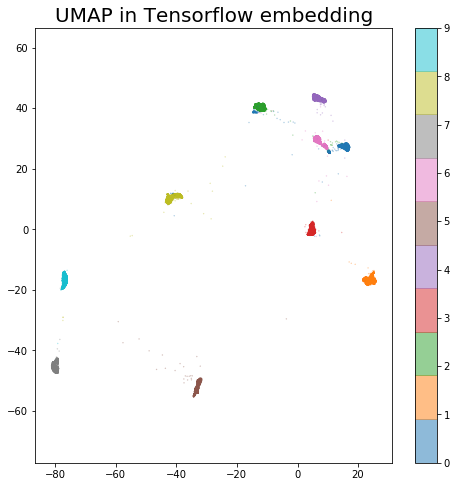

In [112]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

In [113]:
history.history.keys()

dict_keys(['loss', 'classifier_loss', 'umap_loss', 'classifier_accuracy', 'val_loss', 'val_classifier_loss', 'val_umap_loss', 'val_classifier_accuracy'])

Text(0.5, 1.0, 'classifier acc')

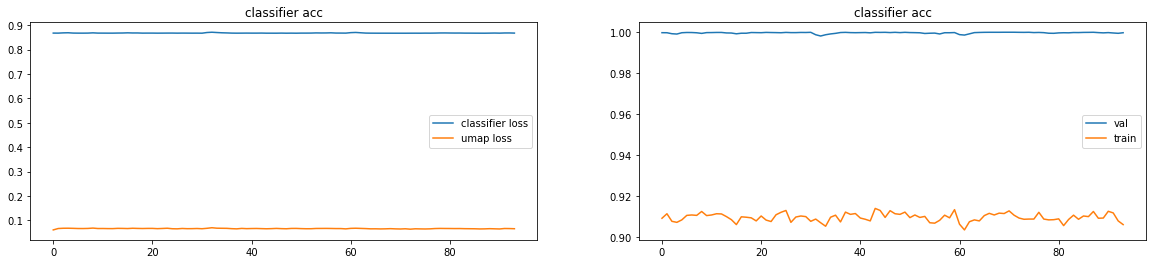

In [119]:
fig, axs = plt.subplots(ncols = 2, figsize=(20,4))

ax = axs[0]
ax.plot(history.history['classifier_loss'], label='classifier loss')
ax.plot(history.history['umap_loss'], label='umap loss')
ax.set_title("classifier acc")
ax.legend()
ax = axs[1]
ax.plot(history.history['classifier_accuracy'], label='val')
ax.plot(history.history['val_classifier_accuracy'], label='train')
ax.legend()
ax.set_title("classifier acc")